<a href="https://colab.research.google.com/github/AdvaitaMenon/Automated-Stock-Portfolio-Tracker/blob/main/Automated_Stock_Portfolio_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages if running in Google Colab or a local Jupyter Notebook
!pip install yfinance matplotlib pandas numpy scipy

[*********************100%***********************]  5 of 5 completed
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Sharpe Ratio (In-sample): Ticker
AAPL     0.877430
AMZN     1.038505
GOOGL    0.836693
MSFT     1.217127
TSLA     0.919666
dtype: float64
Sortino Ratio (In-sample): Ticker
AAPL     1.161946
AMZN     1.441981
GOOGL    1.250058
MSFT     1.666803
TSLA     1.387448
dtype: float64
Maximum Drawdown (In-sample): Ticker
AAPL    -0.385159
AMZN    -0.341038
GOOGL   -0.234018
MSFT    -0.182280
TSLA    -0.535143
dtype: float64
Value at Risk (In-sample, 95% Confidence): nan
Optimized Portfolio Weights (In-sample): {'AAPL': 0.1435840935232803, 'MSFT': 0.18300820491993872, 'GOOGL': 0.05, 'TSLA': 0.46248665302938824, 'AMZN': 0.16092104852739295}


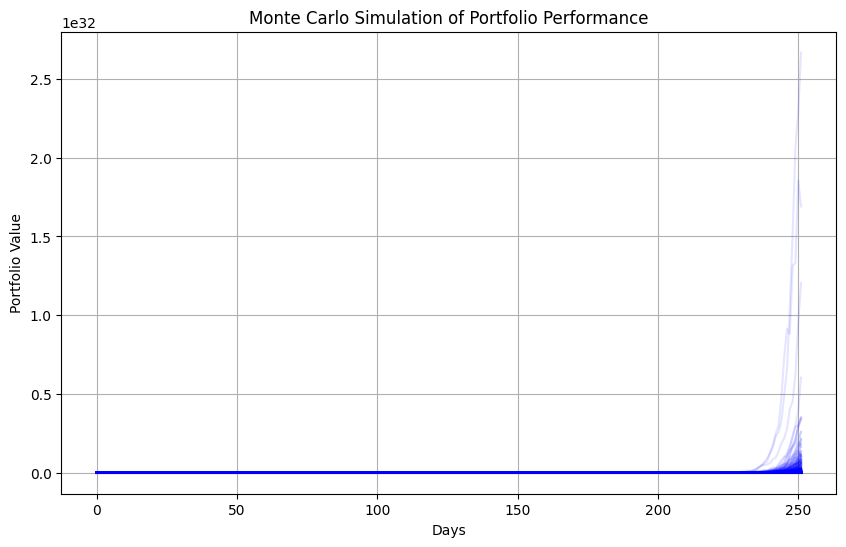

<Figure size 1000x600 with 0 Axes>

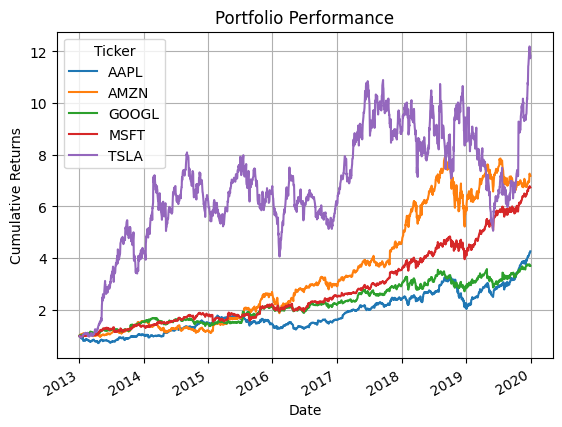

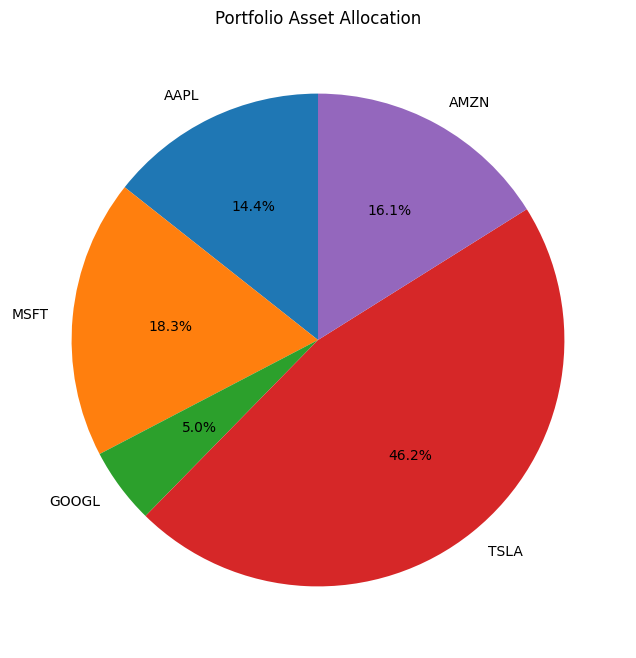

<Figure size 1000x600 with 0 Axes>

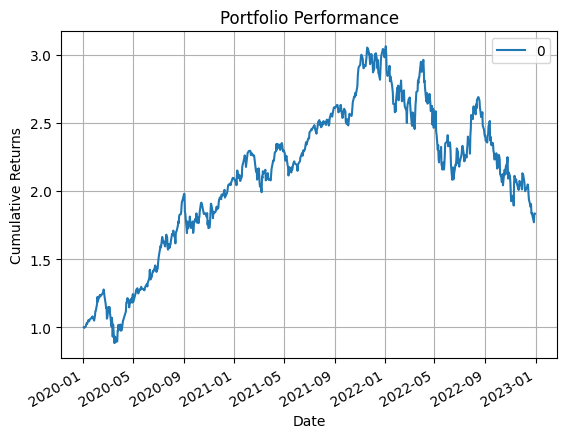

Sharpe Ratio (Out-of-sample): 0    0.692873
dtype: float64
Maximum Drawdown (Out-of-sample): 0   -0.421806
dtype: float64


In [29]:
# Install necessary packages
!pip install yfinance matplotlib pandas numpy scipy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Fetch stock data
def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

# Calculate daily returns
def calculate_daily_returns(stock_data):
    return stock_data.pct_change()

# Calculate cumulative returns
def calculate_cumulative_returns(daily_returns):
    return (1 + daily_returns).cumprod()

# Calculate risk metrics
def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.02):
    excess_returns = daily_returns.mean() - risk_free_rate / 252
    annualized_sharpe = np.sqrt(252) * (excess_returns / daily_returns.std())
    return annualized_sharpe

def calculate_sortino_ratio(daily_returns, risk_free_rate=0.02):
    downside_risk = daily_returns[daily_returns < 0].std() * np.sqrt(252)
    excess_return = daily_returns.mean() * 252 - risk_free_rate
    return excess_return / downside_risk

def calculate_max_drawdown(cumulative_returns):
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_value_at_risk(daily_returns, confidence_level=0.95):
    return np.percentile(daily_returns, (1 - confidence_level) * 100)

# Portfolio Optimization
def portfolio_optimization(daily_returns, risk_free_rate=0.02):
    mean_returns = calculate_annualized_return(daily_returns)
    cov_matrix = daily_returns.cov() * 252  # Annualized covariance matrix
    num_assets = len(mean_returns)

    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_std_dev  # Negative for minimization

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}  # Sum of weights must be 1
    bounds = tuple((0.05, 0.95) for asset in range(num_assets))  # Minimum 5% allocation

    initial_weights = num_assets * [1. / num_assets]
    optimized = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=[constraints])

    return optimized.x

# Monte Carlo Simulation
def monte_carlo_simulation(daily_returns, weights, num_simulations=1000, time_horizon=252):
    mean_returns = calculate_annualized_return(daily_returns)
    cov_matrix = daily_returns.cov() * 252
    num_assets = len(mean_returns)

    results = np.zeros((num_simulations, time_horizon))

    for i in range(num_simulations):
        simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, time_horizon)
        portfolio_returns = np.dot(simulated_returns, weights)
        portfolio_returns = np.clip(portfolio_returns, -0.99, 0.99)  # Cap at -99% and 99%
        results[i, :] = (1 + portfolio_returns).cumprod()

    return results

# Visualization Functions
def plot_monte_carlo_simulation(simulation_results):
    plt.figure(figsize=(10, 6))
    plt.plot(simulation_results.T, color='blue', alpha=0.1)  # Light gray for many simulations
    plt.title('Monte Carlo Simulation of Portfolio Performance')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.show()

def plot_portfolio_performance(cumulative_returns):
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot()
    plt.title("Portfolio Performance")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

def plot_asset_allocation(weights, tickers):
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=90)
    plt.title('Portfolio Asset Allocation')
    plt.show()

# Backtesting Function
def backtest_portfolio(stock_data, portfolio_weights, rebalance_period=21):
    daily_returns = calculate_daily_returns(stock_data)
    portfolio_returns = np.zeros(len(daily_returns))

    for period in range(0, len(daily_returns), rebalance_period):
        weight_idx = min(period // rebalance_period, len(portfolio_weights) - 1)
        current_weights = portfolio_weights[weight_idx]
        period_end = min(period + rebalance_period, len(daily_returns))
        portfolio_returns[period:period_end] = (daily_returns[period:period_end] * current_weights).sum(axis=1)

    cumulative_returns = calculate_cumulative_returns(pd.DataFrame(portfolio_returns, index=daily_returns.index))
    sharpe_ratio = calculate_sharpe_ratio(pd.DataFrame(portfolio_returns))
    max_drawdown = calculate_max_drawdown(cumulative_returns)

    return cumulative_returns, sharpe_ratio, max_drawdown

# Main Execution with Train-Test Split
if __name__ == "__main__":
    # Example portfolio
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN']
    start_date = '2013-01-01'
    end_date = '2023-01-01'

    # Fetch stock data
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Split data into training (in-sample) and testing (out-of-sample) periods
    split_index = int(len(stock_data) * 0.7)  # Use 70% for training and 30% for testing
    stock_data_train = stock_data[:split_index]  # In-sample data for optimization
    stock_data_test = stock_data[split_index:]  # Out-of-sample data for backtesting

    # Calculate daily returns for training and testing periods
    daily_returns_train = calculate_daily_returns(stock_data_train)
    daily_returns_test = calculate_daily_returns(stock_data_test)

    # Calculate cumulative returns for both periods
    cumulative_returns_train = calculate_cumulative_returns(daily_returns_train)
    cumulative_returns_test = calculate_cumulative_returns(daily_returns_test)

    # Calculate Risk Metrics on Training (in-sample) Period
    sharpe_ratio_train = calculate_sharpe_ratio(daily_returns_train)
    sortino_ratio_train = calculate_sortino_ratio(daily_returns_train)
    max_drawdown_train = calculate_max_drawdown(cumulative_returns_train)
    var_train = calculate_value_at_risk(daily_returns_train)

    # Print in-sample risk metrics
    print(f"Sharpe Ratio (In-sample): {sharpe_ratio_train}")
    print(f"Sortino Ratio (In-sample): {sortino_ratio_train}")
    print(f"Maximum Drawdown (In-sample): {max_drawdown_train}")
    print(f"Value at Risk (In-sample, 95% Confidence): {var_train}")

    # Optimize Portfolio using In-Sample Data (Training Period)
    optimized_weights = portfolio_optimization(daily_returns_train)
    print(f"Optimized Portfolio Weights (In-sample): {dict(zip(tickers, optimized_weights))}")

    # Monte Carlo Simulation using Optimized Weights from In-Sample Data
    simulation_results = monte_carlo_simulation(daily_returns_train, optimized_weights)
    plot_monte_carlo_simulation(simulation_results)

    # Plot Cumulative Returns for In-Sample Period
    plot_portfolio_performance(cumulative_returns_train)
    plot_asset_allocation(optimized_weights, tickers)

    # Backtest the Portfolio on Out-of-Sample Data (Testing Period)
    portfolio_weights_history = [optimized_weights]  # Use the optimized weights for backtesting
    cumulative_returns_backtest, sharpe_ratio_backtest, max_drawdown_backtest = backtest_portfolio(stock_data_test, portfolio_weights_history)

    # Plot Backtested Performance
    plot_portfolio_performance(cumulative_returns_backtest)
    print(f"Sharpe Ratio (Out-of-sample): {sharpe_ratio_backtest}")
    print(f"Maximum Drawdown (Out-of-sample): {max_drawdown_backtest}")
